# __K-Means clustering__

## Requirements for notebook
!pip install useful_rdkit_utils pandas scikit-learn tqdm numpy seaborn mols2grid matplotlib

In [9]:
import pandas as pd
import useful_rdkit_utils as urdkit
from rdkit import Chem
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import mols2grid
import matplotlib.cm as cm

# Set the progress bar for pandas when executed
tqdm.pandas()

# Set up aesthetics for seaborn plots
sns.set_theme()
sns.set_theme(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

In [10]:
# Read in the input data
url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/cluster_test.smi"
df = pd.read_csv(url, sep=" ", names=["SMILES", "NAME"])
df.head()

,SMILES,NAME
0,CCC(=O)/N=C1\S[C@H]2CS(=O)(=O)C[C@@H]2N1c1ccc(...,16741133
1,Cc1ccc(Cl)cc1N1/C(=N\C(=O)CCC(=O)O)S[C@H]2CS(=...,101303273
2,CCCCC(=O)/N=C1/S[C@H]2CS(=O)(=O)C[C@@H]2N1c1cc...,32504126
3,CCN(CC)c1ccc(N2/C(=N\C(=O)CC#N)S[C@H]3CS(=O)(=...,101319242
4,CC[C@H](C)C(=O)/N=C1/S[C@H]2CS(=O)(=O)C[C@H]2N...,36638719


In [14]:
# Adding RDkit Mlecule using smiles
# A quicker way to make rdkit molecules using smiles
df['rdkit_mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)
mols2grid.display(df["rdkit_mol"])


  0%|          | 0/735 [00:00<?, ?it/s]

MolGridWidget()

In [17]:
# make rdkit morgan fingerprints
df['morgan_fp'] = df.rdkit_mol.progress_apply(urdkit.mol2morgan_fp)
df.head()

  0%|          | 0/735 [00:00<?, ?it/s]

,SMILES,NAME,rdkit_mol,morgan_fp
0,CCC(=O)/N=C1\S[C@H]2CS(=O)(=O)C[C@@H]2N1c1ccc(...,16741133,<rdkit.Chem.rdchem.Mol object at 0x177a89a80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1ccc(Cl)cc1N1/C(=N\C(=O)CCC(=O)O)S[C@H]2CS(=...,101303273,<rdkit.Chem.rdchem.Mol object at 0x177a899a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCCCC(=O)/N=C1/S[C@H]2CS(=O)(=O)C[C@@H]2N1c1cc...,32504126,<rdkit.Chem.rdchem.Mol object at 0x177a89850>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CCN(CC)c1ccc(N2/C(=N\C(=O)CC#N)S[C@H]3CS(=O)(=...,101319242,<rdkit.Chem.rdchem.Mol object at 0x177a89700>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CC[C@H](C)C(=O)/N=C1/S[C@H]2CS(=O)(=O)C[C@H]2N...,36638719,<rdkit.Chem.rdchem.Mol object at 0x177a89620>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
# Converting morgan fingerprints to a X matrix for sklearn
X = np.stack(df.morgan_fp)

# Clustering with k-means 
num_clusters = 5
km = KMeans(n_clusters=num_clusters,
            random_state=42, 
            n_init='auto')
km.fit(X)
cluster_list = km.predict(X)

Text(0.5, 1.0, 'Cluster Population')

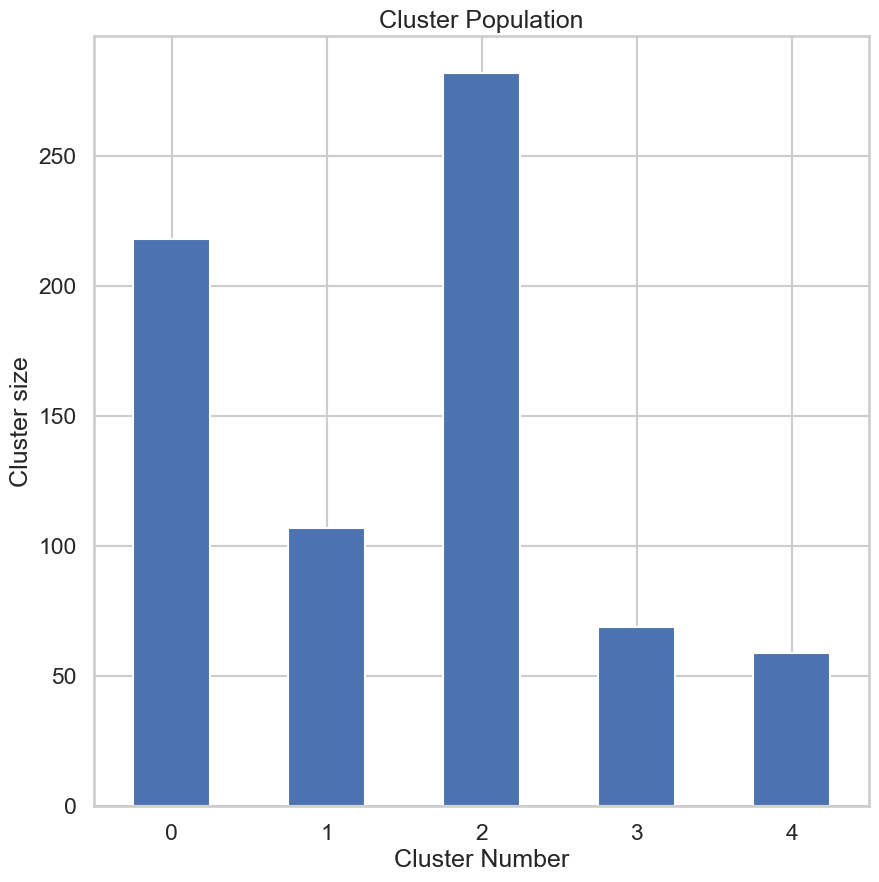

In [21]:
# Plot clustering results to understand cluster population
# Need to sort index as it is not sequential
ax = pd.Series(cluster_list).value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Cluster Number')
ax.set_ylabel('Cluster size') # Number of molucules in cluster
ax.tick_params(axis='x', rotation=0)
ax.set_title('Cluster Population')

In [30]:
# Optimizing the hyperparamters n_cluster of the k-means model
cluster_range = range(5,25)
score_list = []
# Making a for loop to iterate through the range of clusters
for k in tqdm(cluster_range):
    km = KMeans(n_clusters=k,random_state=42,n_init='auto')
    cluster_labels = km.fit_predict(X)
    # Using the silhouette score to evaluate the quality of the clustering
    # The silhouette score ranges from -1 to 1
    # A score of 1 indicates that the sample is well clustered
    # A score of -1 indicates that the sample is poorly clustered
    score = silhouette_score(X,cluster_labels)
    #Appending the score to the list
    score_list.append([k,score])

# Making a dataframe from the list
score_df = pd.DataFrame(score_list,columns=["K","Silhouette Score"])


  0%|          | 0/20 [00:00<?, ?it/s]

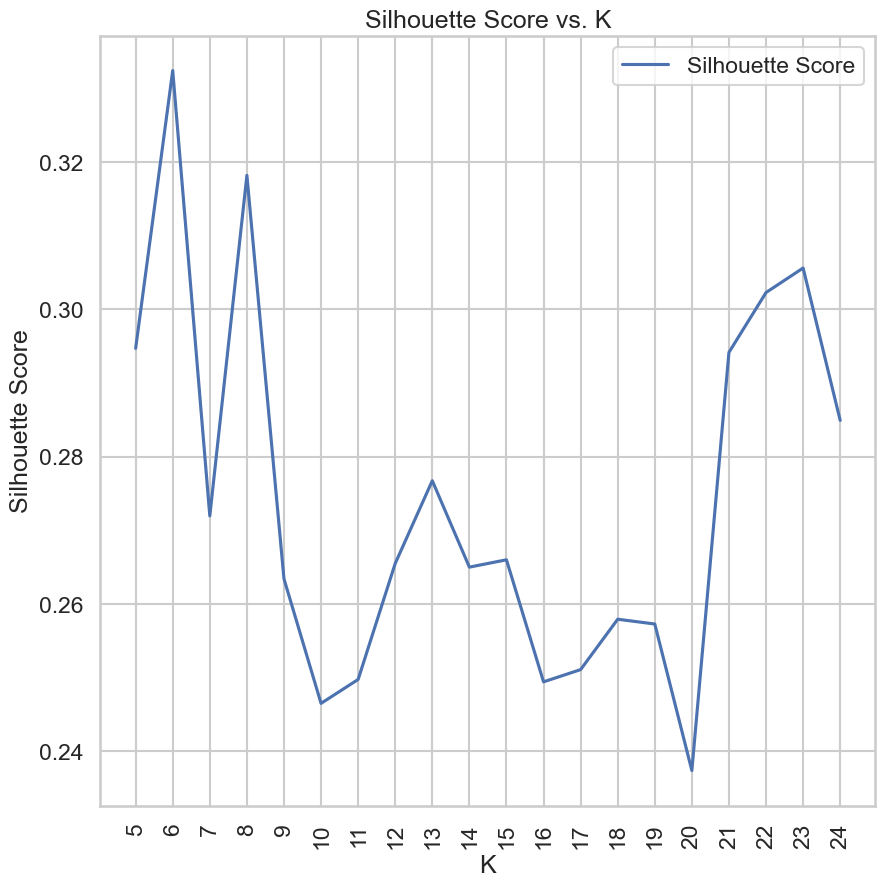

In [36]:
# Plotting the results of cluster number vs silhouette score
ax = score_df.plot(x="K",y="Silhouette Score")
ax.set_xlabel('K')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs. K')
ax.tick_params(axis='x', rotation=90)
ax.set_xticks(cluster_range)

In [42]:
# Testing the best and worst cluster number for the k-means model
best_cluster = 6
worst_cluster = 20

km_best = KMeans(n_clusters=best_cluster,random_state=42,n_init='auto')
cluster_best = km_best.fit_predict(X)

km_worst = KMeans(n_clusters=worst_cluster,random_state=42,n_init='auto')
cluster_worst = km_worst.fit_predict(X)

In [44]:
# Making a plot used for silhoette score analysis
def silhouette_plot(X,cluster_labels):
    """
    Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    sns.set_style('whitegrid')
    sample_df = pd.DataFrame(silhouette_samples(X,cluster_labels),columns=["Silhouette"])
    sample_df['Cluster'] = cluster_labels
    n_clusters = max(cluster_labels+1)
    color_list = [cm.nipy_spectral(float(i) / n_clusters) for i in range(0,n_clusters)]
    ax = sns.scatterplot()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    y_lower = 10
    unique_cluster_ids = sorted(sample_df.Cluster.unique())
    for i in unique_cluster_ids:
        cluster_df = sample_df.query('Cluster == @i')
        cluster_size = len(cluster_df)
        y_upper = y_lower + cluster_size
        ith_cluster_silhouette_values = cluster_df.sort_values("Silhouette").Silhouette.values
        color = color_list[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i),fontsize="small")
        y_lower = y_upper + 10
    ax.axvline(silhouette_avg,color="red",ls="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster")
    ax.set(yticklabels=[]) 
    ax.yaxis.grid(False) 

## **What are we looking for when inspecting the silohette plot**

1. How uniform are the sizes of the clusters (represeneted by the widths of the bars in the plot below).
2. How consistent are the Silhoutte Scores for the inidividual clusters.

The average line is shown in red

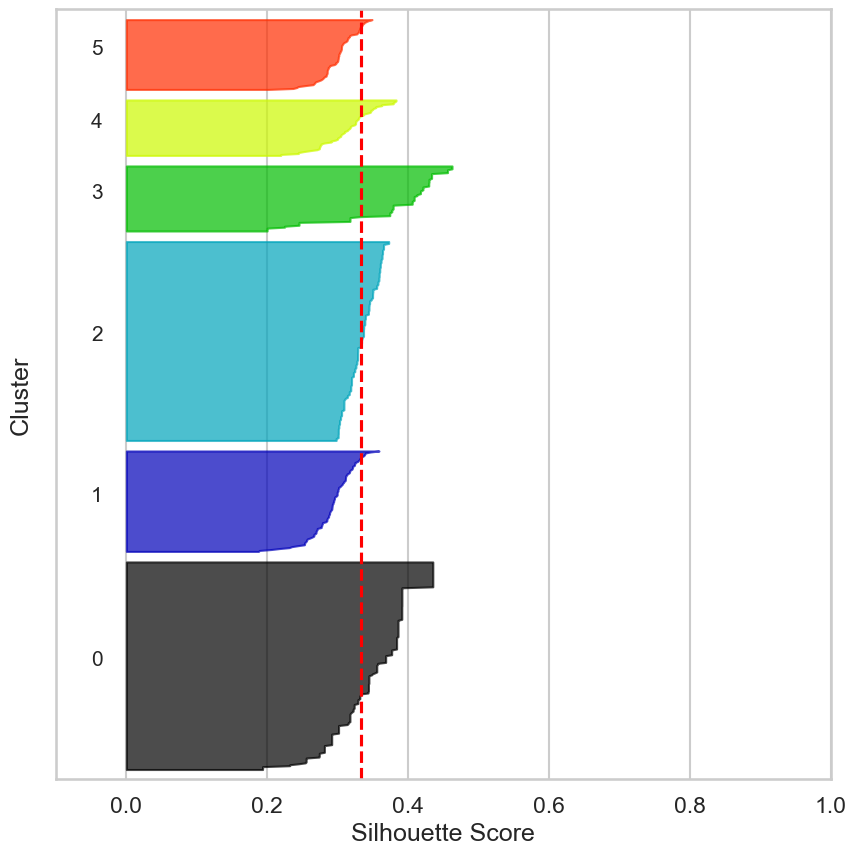

In [45]:
# Showing the silohette plot for the best cluster
# One can see how the scores similar and 4 of the 6 cluster thickness is similar
silhouette_plot(X, cluster_best)

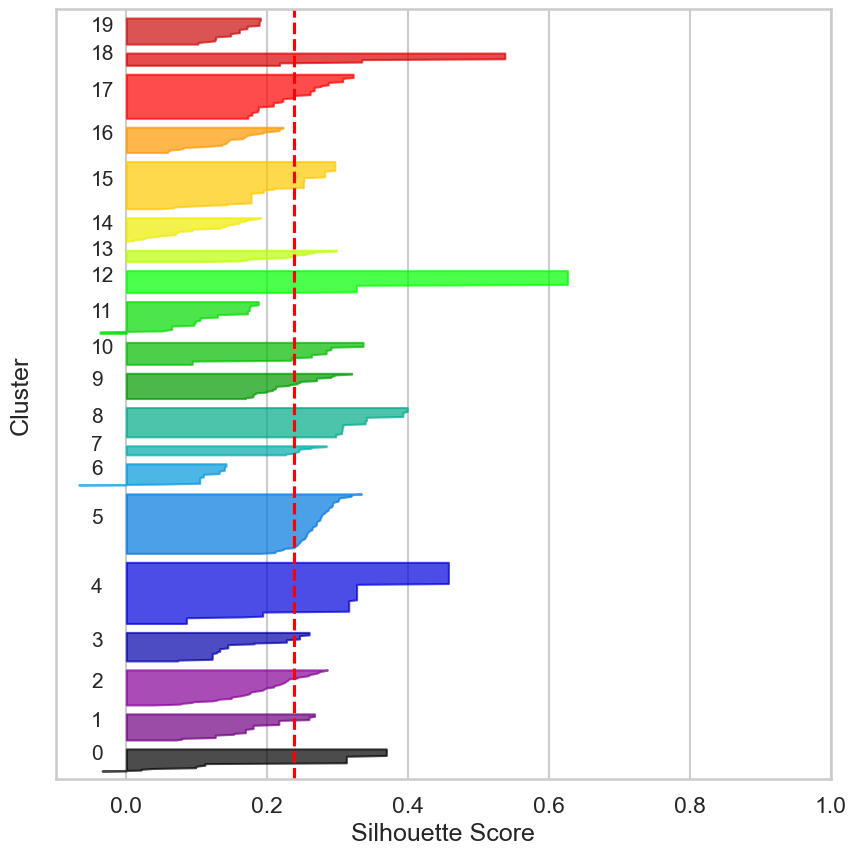

In [46]:
# Showing the silohette plot for the worst cluster
# One can see how the scores and thickness differ drastically
silhouette_plot(X, cluster_worst)

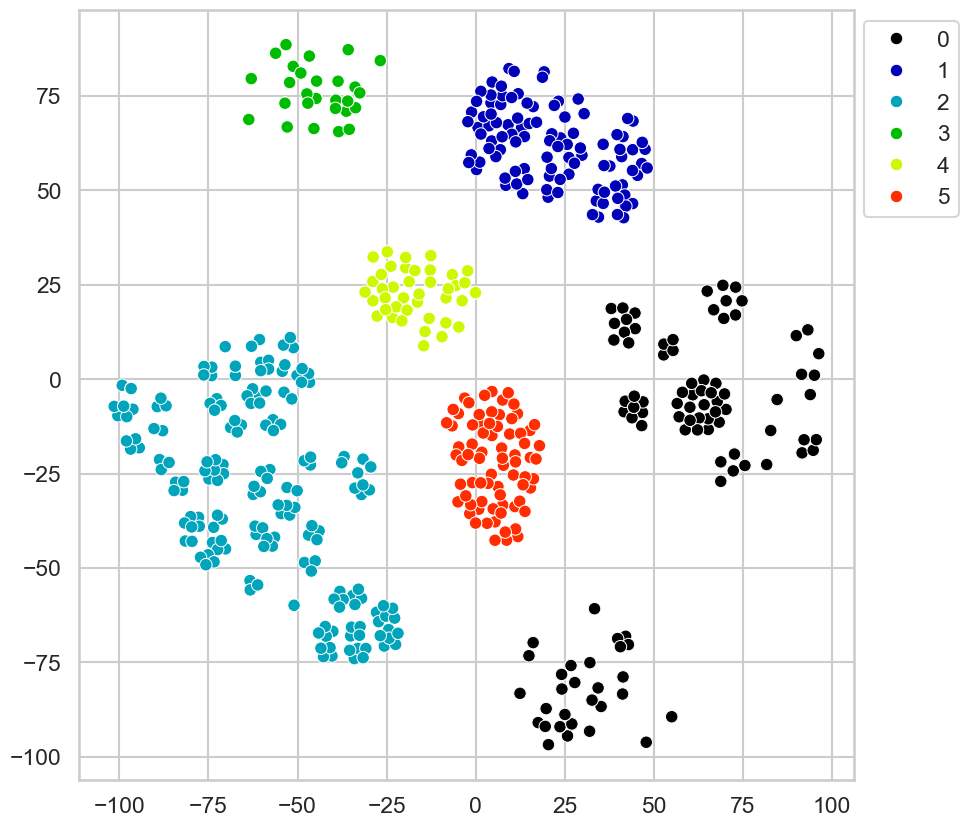

In [58]:
# Making a TSNE plot of the clustering for the best plot to understand the clustering
tsne = TSNE(n_components=2, 
            init='pca', 
            learning_rate='auto', 
            random_state=42)

crds = tsne.fit_transform(X, cluster_best)
color_list = [cm.nipy_spectral(float(i) / best_cluster) for i in range(0,best_cluster)]

ax = sns.scatterplot(x=crds[:,0],
                     y=crds[:,1],
                     hue=cluster_best,
                     palette=color_list, 
                     legend=True)
ax.legend(bbox_to_anchor=(1.15, 1.0), ncol=1)

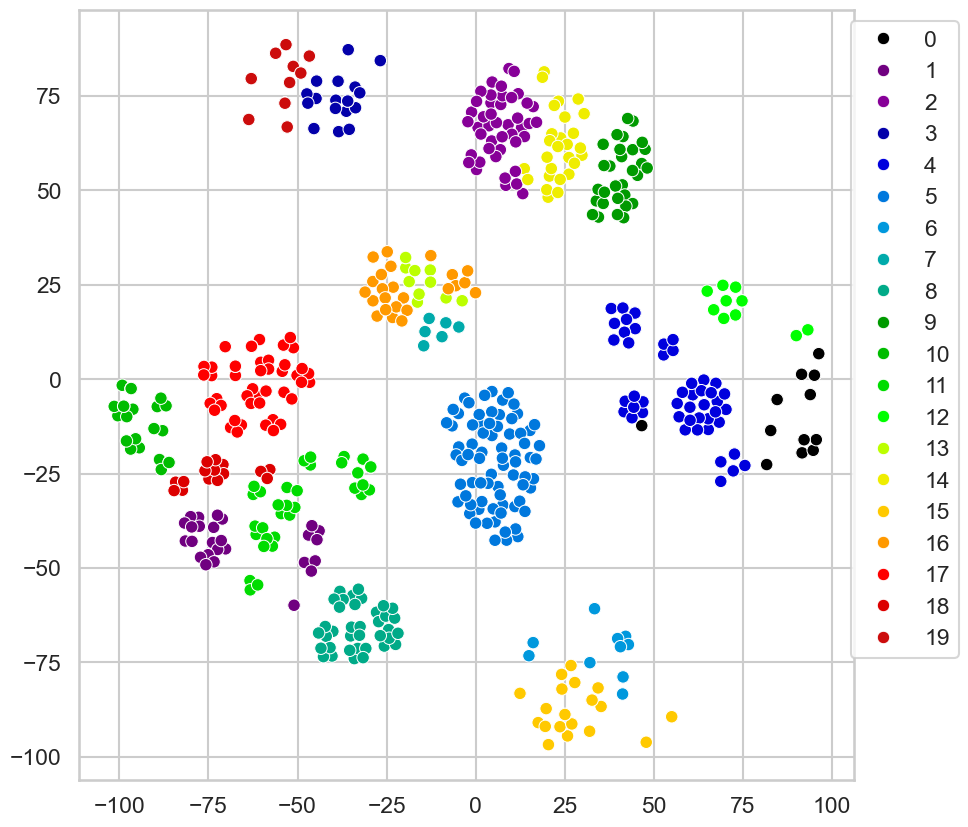

In [56]:
# Making a TSNE plot of the clustering for the worst plot to understand the clustering
tsne = TSNE(n_components=2, 
            init='pca', 
            learning_rate='auto', 
            random_state=42)

crds = tsne.fit_transform(X, cluster_worst)
color_list = [cm.nipy_spectral(float(i) / worst_cluster) for i in range(0, worst_cluster)]
ax = sns.scatterplot(x=crds[:,0],
                     y=crds[:,1],
                     hue=cluster_worst,
                     palette=color_list, 
                     legend=True)
ax.legend(bbox_to_anchor=(1.15, 1.0), ncol=1)

In [59]:
# Adding the cluster labels to a copy of the original dataframe
opt_cluster_df = df.copy()
opt_cluster_df['cluster'] = cluster_best
opt_cluster_df.head()



,SMILES,NAME,rdkit_mol,morgan_fp,cluster
0,CCC(=O)/N=C1\S[C@H]2CS(=O)(=O)C[C@@H]2N1c1ccc(...,16741133,<rdkit.Chem.rdchem.Mol object at 0x177a89a80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
1,Cc1ccc(Cl)cc1N1/C(=N\C(=O)CCC(=O)O)S[C@H]2CS(=...,101303273,<rdkit.Chem.rdchem.Mol object at 0x177a899a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
2,CCCCC(=O)/N=C1/S[C@H]2CS(=O)(=O)C[C@@H]2N1c1cc...,32504126,<rdkit.Chem.rdchem.Mol object at 0x177a89850>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
3,CCN(CC)c1ccc(N2/C(=N\C(=O)CC#N)S[C@H]3CS(=O)(=...,101319242,<rdkit.Chem.rdchem.Mol object at 0x177a89700>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
4,CC[C@H](C)C(=O)/N=C1/S[C@H]2CS(=O)(=O)C[C@H]2N...,36638719,<rdkit.Chem.rdchem.Mol object at 0x177a89620>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2


In [65]:
# Display the dataframe with the cluster labels
cluster_id = 4
cols = ["SMILES","NAME","cluster"]
display_df = opt_cluster_df[cols].query("cluster == @cluster_id")
mols2grid.display(display_df,subset=["NAME","img", "cluster"],n_cols=3,size=(320,240))

MolGridWidget()

In [ ]:
# Save the specified cluster or clusters to a csv file
opt_cluster_df[["SMILES", "NAME", "cluster"]].to_csv("clustered_molecules.csv", index=False)